In [1]:
from language import VerbArguments
from train import train, init_model
from transformers import GPT2Config, GPT2LMHeadModel
import torch

from sklearn.decomposition import PCA
import pandas as pd
import plotnine as p9
from sklearn.feature_selection import r_regression

device = "cpu"

/Users/aryamanarora/Documents/Code/tinylang/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [12]:
language = VerbArguments(num_verbs=20, num_nouns=20)

In [13]:
model_dict = {}
loss_dict = {}

# defaults
n_layers = 2
n_embd = 64
n_head = 2
n_inner = 4

for n_layer in range(0, 4):
# for n_embd in [16, 32, 64, 128]:   
# for n_head in [1, 2, 4, 8]:
# for n_inner in [0.5, 1, 2, 4]:
    config = GPT2Config(
        vocab_size=language.vocab_size,
        n_positions=5,
        n_embd=n_embd,
        n_layer=n_layer,
        n_head=n_head,
        n_inner=int(n_inner * n_embd),
        activation_function="gelu_new",
        resid_pdrop=0.0,
        embd_pdrop=0.0,
        attn_pdrop=0.0,
        layer_norm_epsilon=1e-5,
        initializer_range=0.02,
        summary_type="cls_index",
    )
    model = GPT2LMHeadModel(config).to(device)
    losses = train(model, language, num_steps=10000)
    model.eval()
    loss_dict[n_layer] = losses
    model_dict[n_layer] = model


Parameters: 0.003136M


Training: 100%|███████████████| 10000/10000 [00:19<00:00, 512.27it/s, loss=2.03]


Parameters: 0.05312M


Training: 100%|███████████████| 10000/10000 [00:32<00:00, 303.17it/s, loss=1.92]


Parameters: 0.103104M


Training: 100%|███████████████| 10000/10000 [00:48<00:00, 205.21it/s, loss=1.98]


Parameters: 0.153088M


Training: 100%|███████████████| 10000/10000 [00:56<00:00, 177.69it/s, loss=1.96]


In [32]:
combined_cols = []
for d in loss_dict:
    for i in range(len(loss_dict[d]["train_loss"])):
        add = {metric: loss_dict[d][metric][i] for metric in loss_dict[d]}
        add["index"] = i
        add["d"] = d
        combined_cols.append(add)
df = pd.DataFrame(combined_cols)
df = df.melt(id_vars=["index", "d"]
df

,index,d,variable,value
0,0,0,train_loss,3.725339
1,1,0,train_loss,3.758169
2,2,0,train_loss,3.729244
3,3,0,train_loss,3.737571
4,4,0,train_loss,3.746594
...,...,...,...,...
199995,9995,3,eval_noun2_prob,0.997311
199996,9996,3,eval_noun2_prob,0.997322
199997,9997,3,eval_noun2_prob,0.997327
199998,9998,3,eval_noun2_prob,0.997334


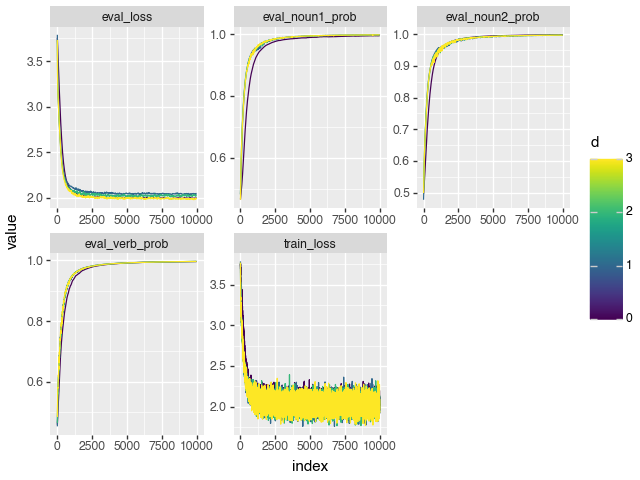

In [40]:
%config InlineBackend.figure_format = 'png'
plot = (
    p9.ggplot(df, p9.aes(x="index", y="value", color="d", group="d")) +
    p9.geom_line() +
    p9.facet_wrap("variable", scales="free")
    # p9.scale_x_log10()
)
plot.show()

/Users/aryamanarora/Documents/Code/tinylang/.venv/lib/python3.13/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


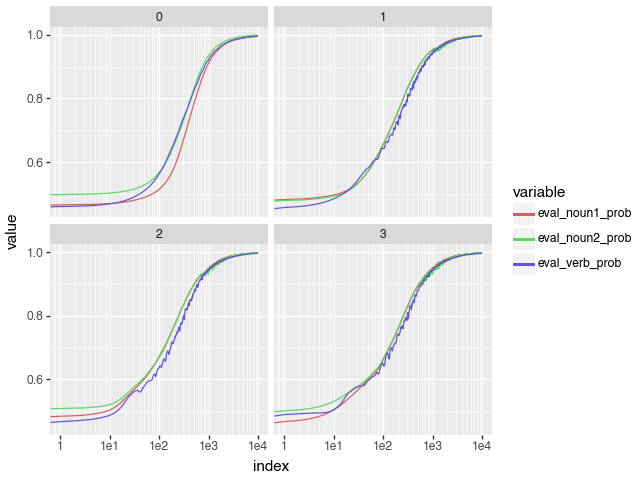

In [37]:
plot = (
    p9.ggplot(df[df['variable'].isin(['eval_verb_prob', 'eval_noun1_prob', 'eval_noun2_prob'])], p9.aes(x="index", y="value", color="variable", group="variable")) +
    p9.geom_line() +
    p9.facet_wrap("d") +
    p9.scale_x_log10()
)
plot.show()

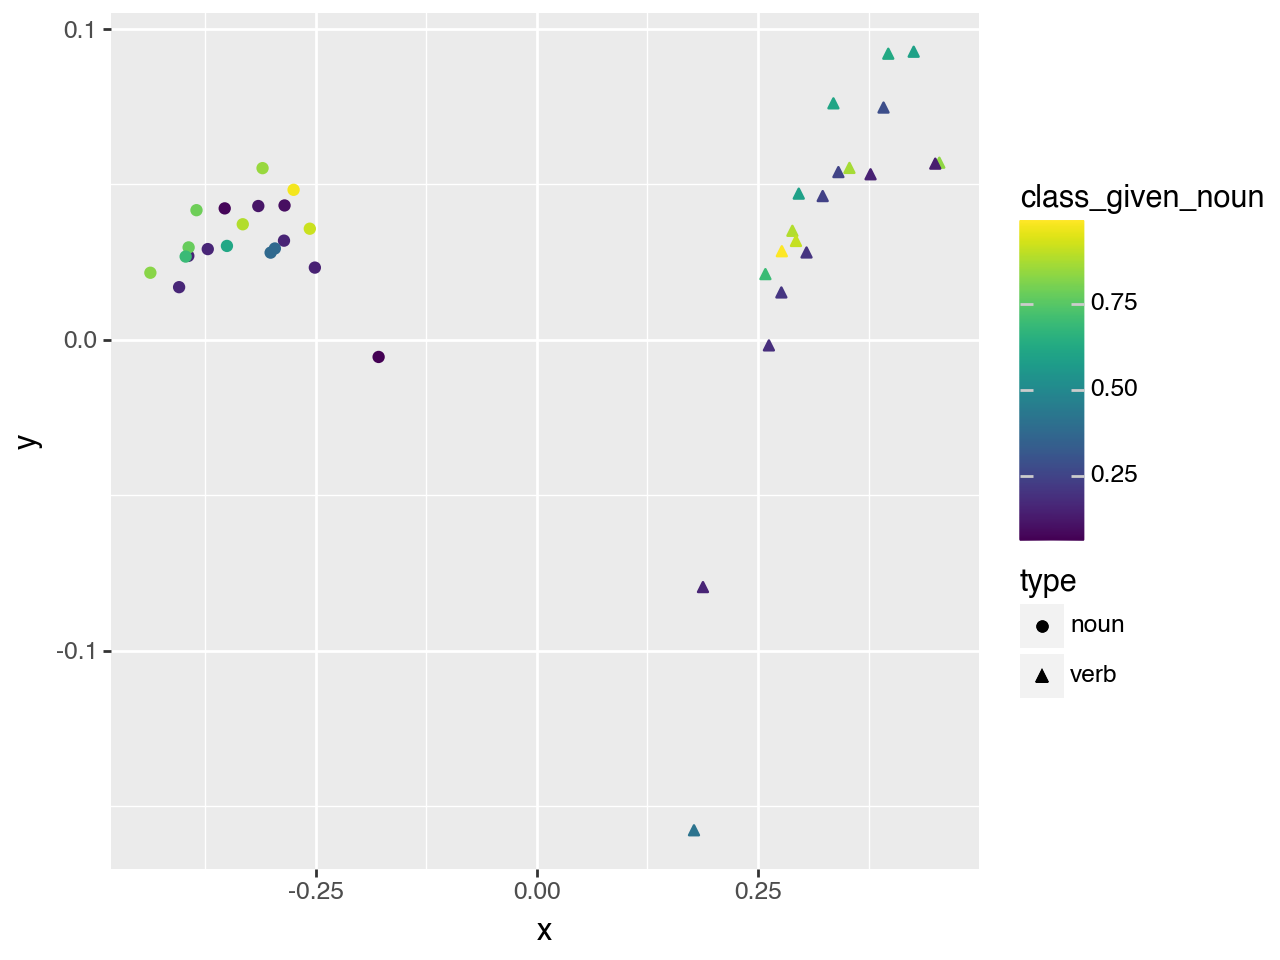

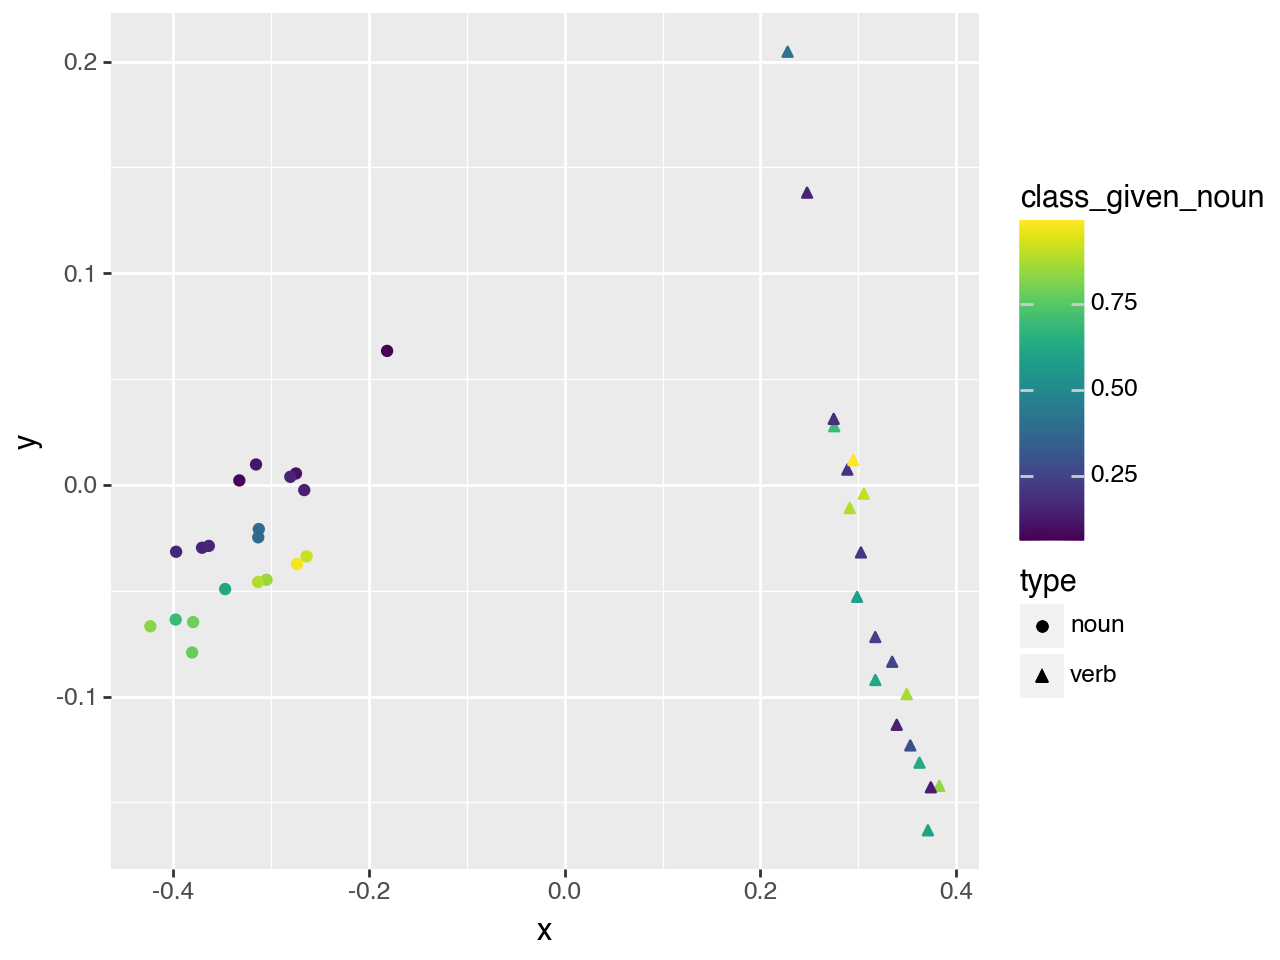

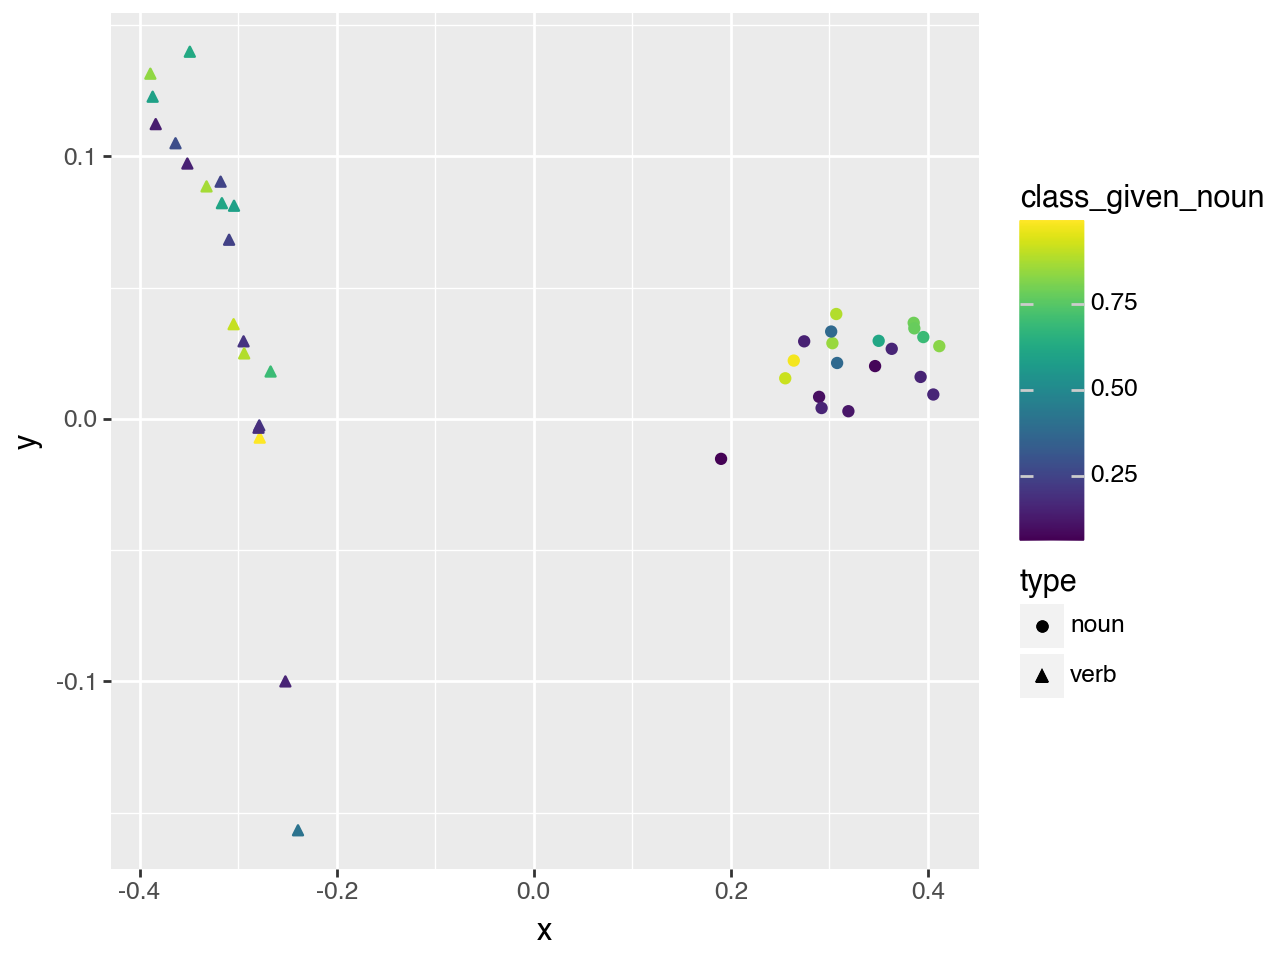

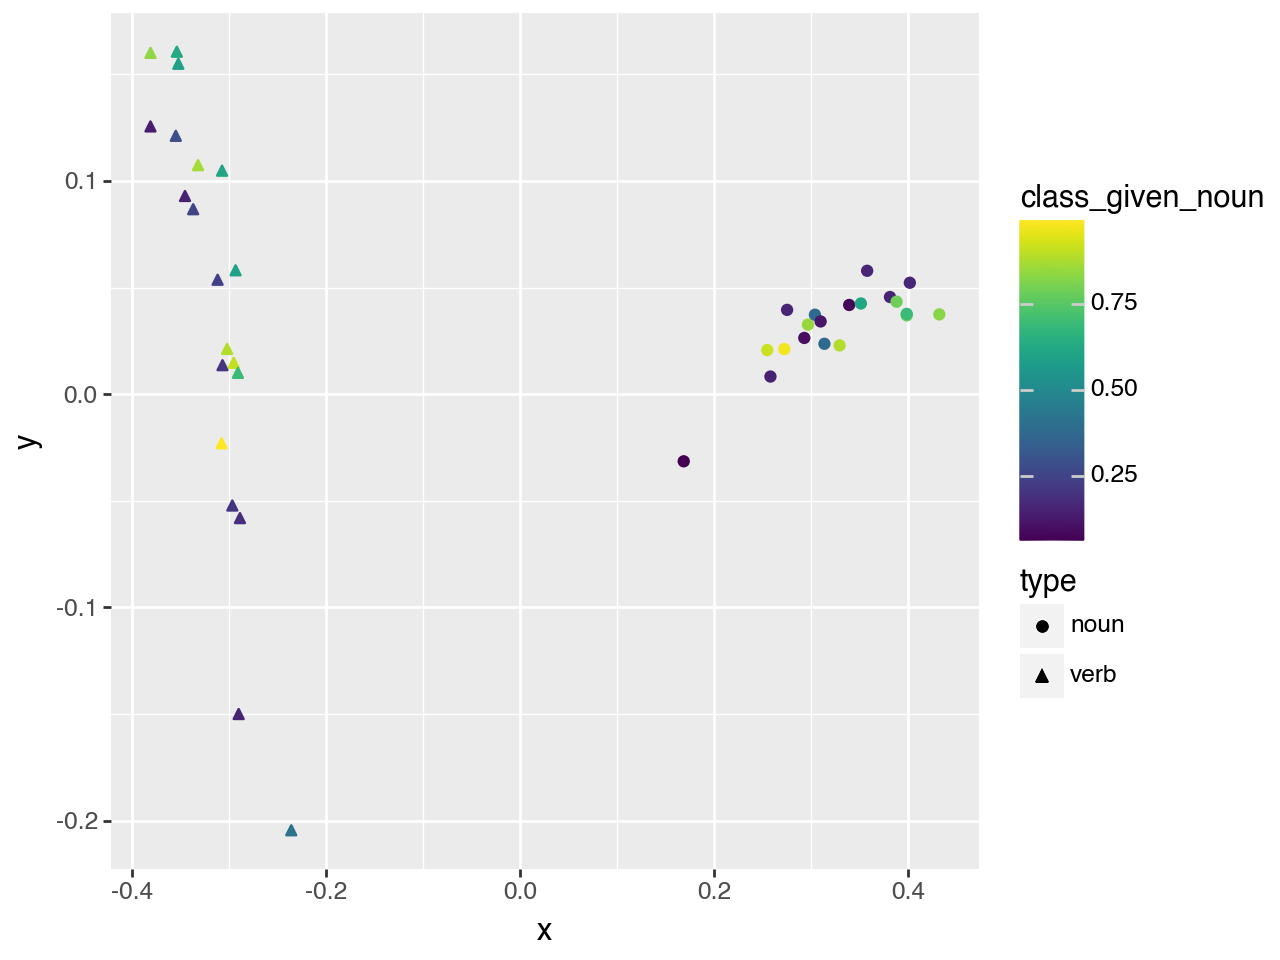

In [17]:
dfs = {}
for d in model_dict:
    model = model_dict[d]
    embeddings = model.transformer.wte.weight.data
    pca = PCA(n_components=5)
    embeddings_pca = pca.fit_transform(embeddings)

    # make data frame
    def color_by_verb_noun(i):
        if i == language.BOS:
            return "bos"
        elif i == language.EOS:
            return "eos"
        elif i < language.VERB_START:
            return "other"
        elif i < language.NOUN_START:
            return "verb"
        else:
            return "noun"
    df = pd.DataFrame(embeddings_pca[:, :2], columns=['x', 'y'])
    df['type'] = df.index.map(color_by_verb_noun)
    df['order_given_verb'] = df.index.map(lambda i: language.p_order_given_verb[i - language.VERB_START, 0].item() if i >= language.VERB_START and i < language.NOUN_START else None)
    df['class_given_noun'] = df.index.map(lambda i: language.p_class_given_noun[i - language.NOUN_START, 0].item() if i >= language.NOUN_START else None)
    df['index'] = df.index.map(lambda i: i)
    dfs[d] = df

    plot = (
        p9.ggplot(p9.aes(x='x', y='y', shape='type'))
        + p9.geom_point(df[df['type'] == 'noun'], p9.aes(color='class_given_noun'))
        + p9.geom_point(df[df['type'] == 'verb'], p9.aes(color='order_given_verb'))
    )
    plot.show()


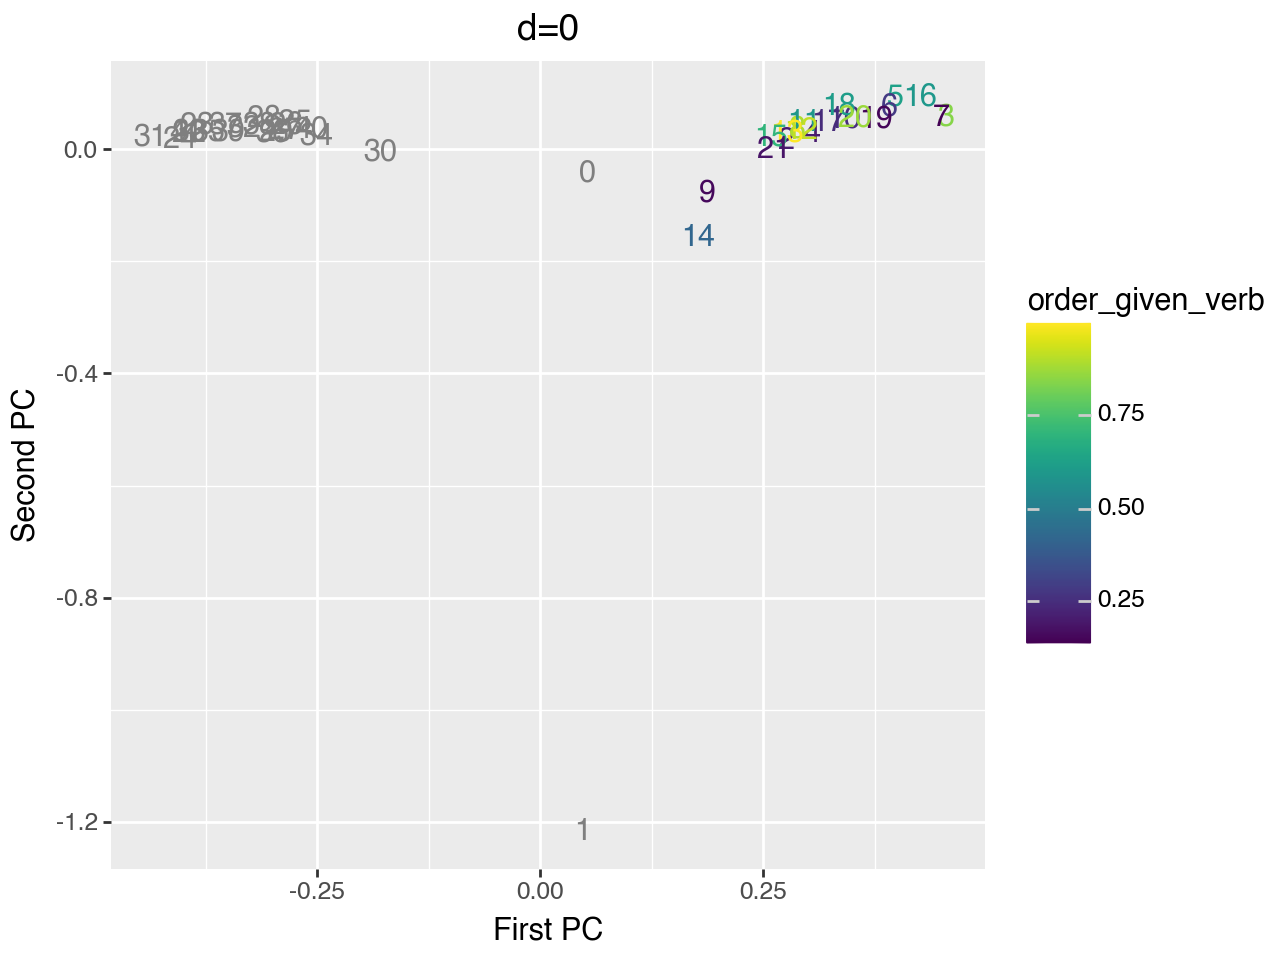

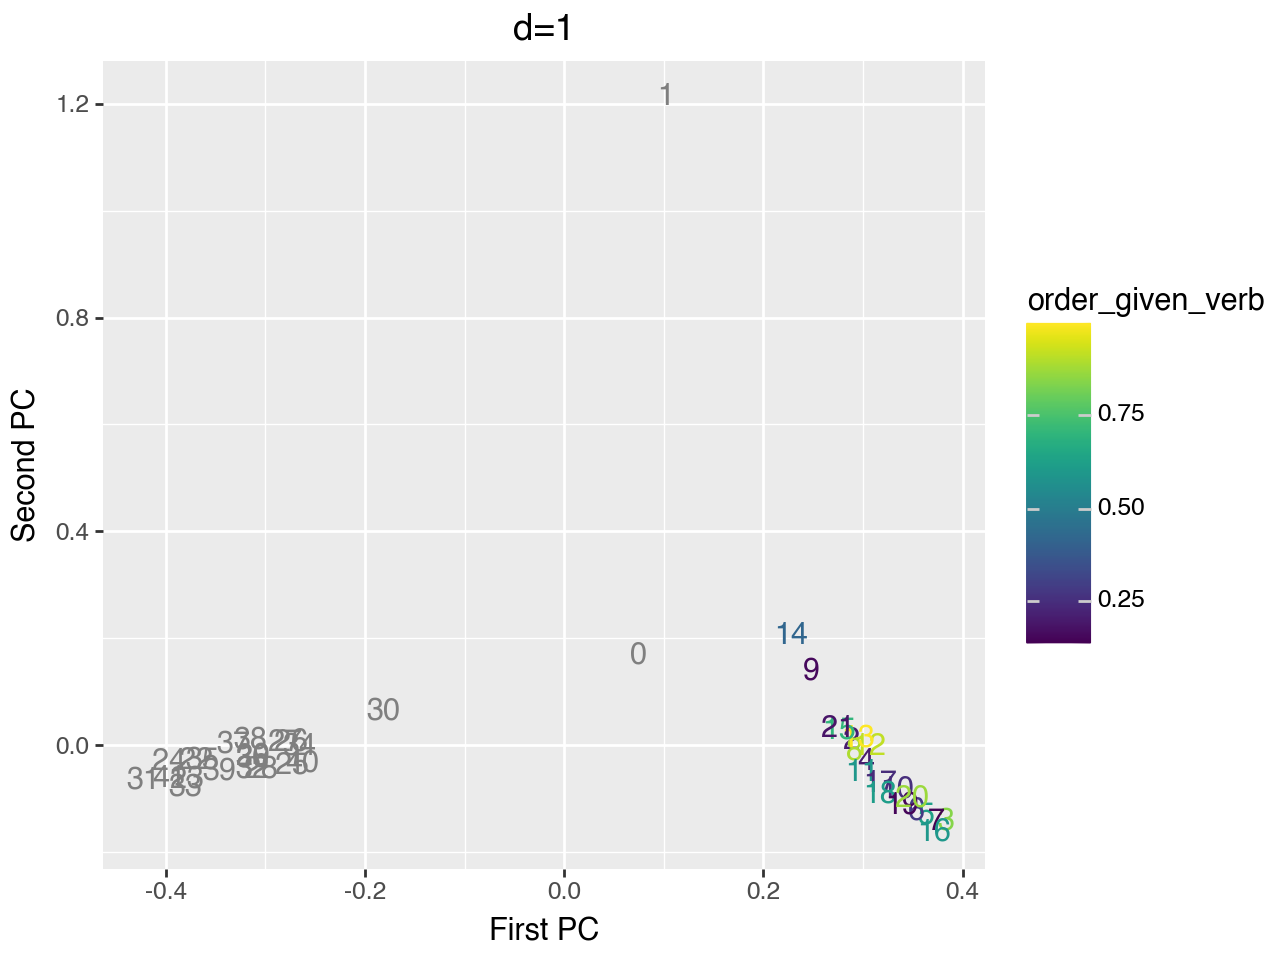

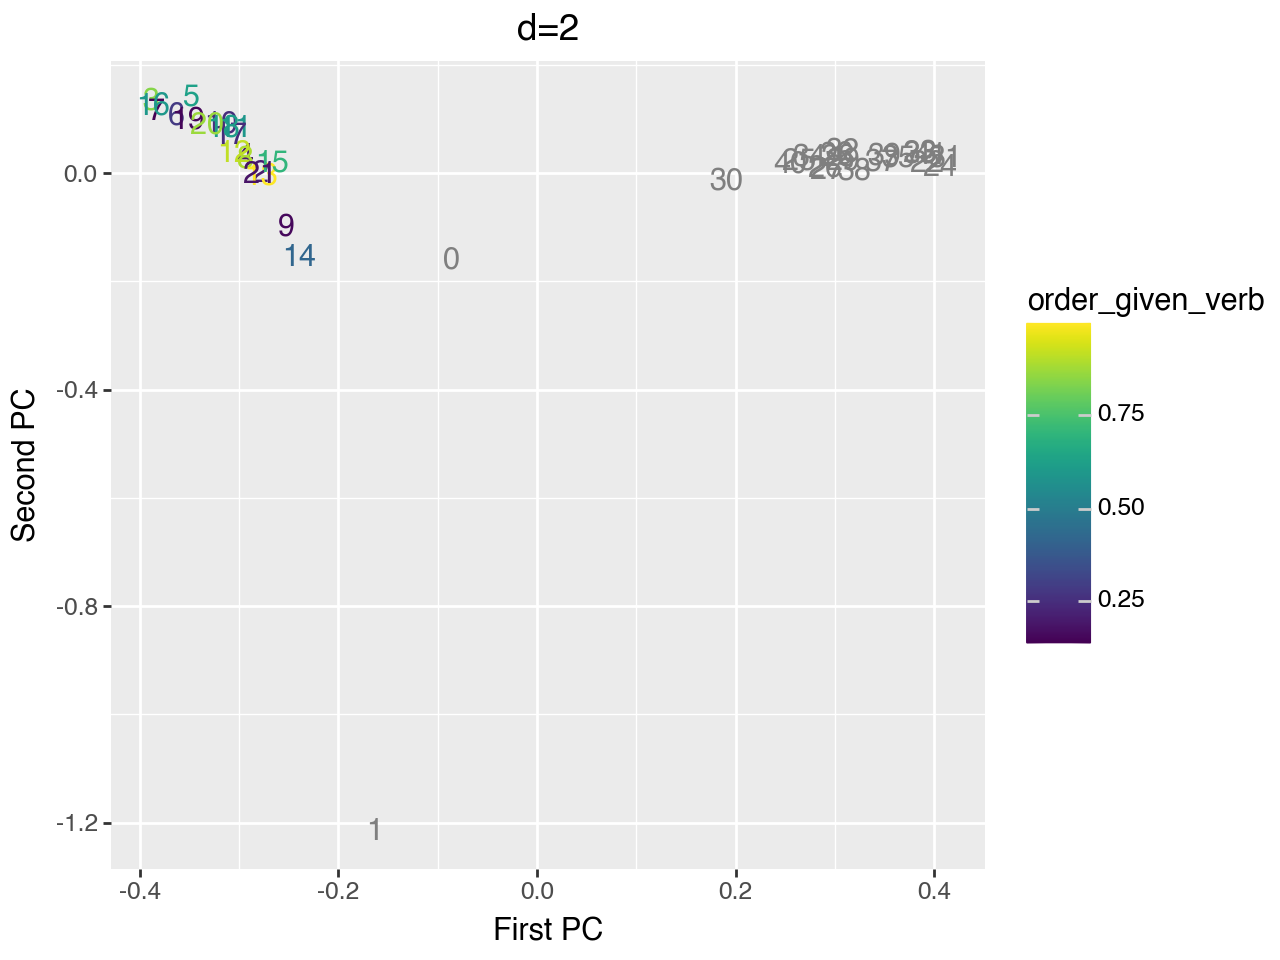

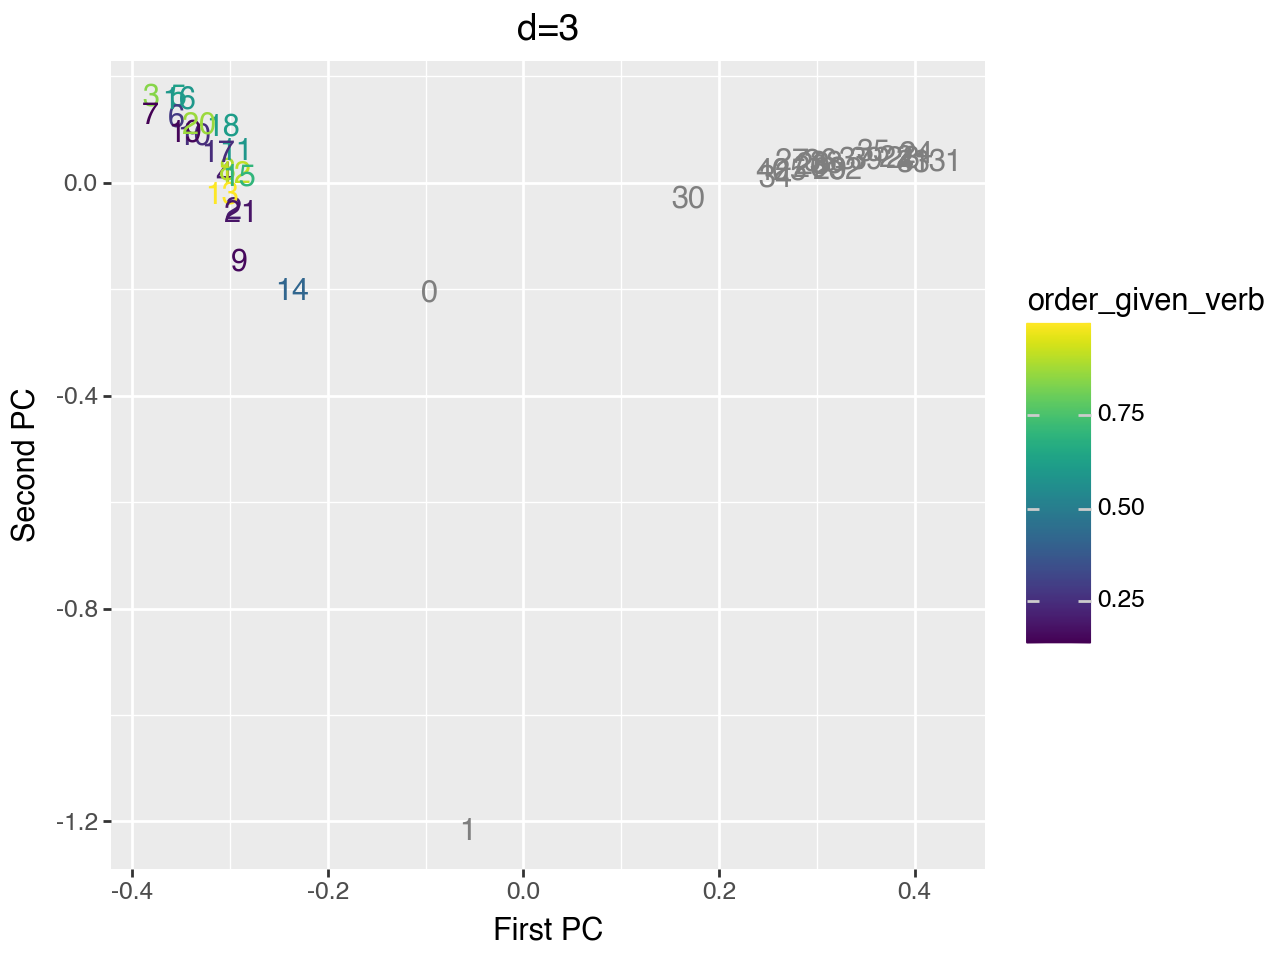

In [18]:
for d in model_dict:
    df = dfs[d]
    plot = (
        p9.ggplot(df, p9.aes(x='x', y='y', color='order_given_verb'))
        + p9.geom_text(p9.aes(label='index'))
        + p9.labs(x="First PC", y="Second PC", title=f"d={d}")
    )
    plot.show()


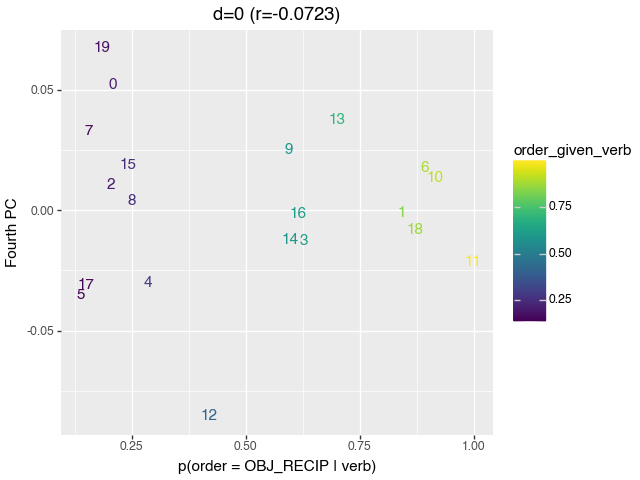

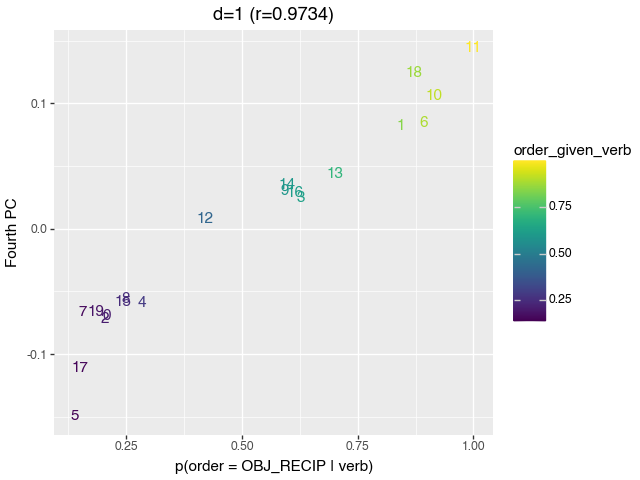

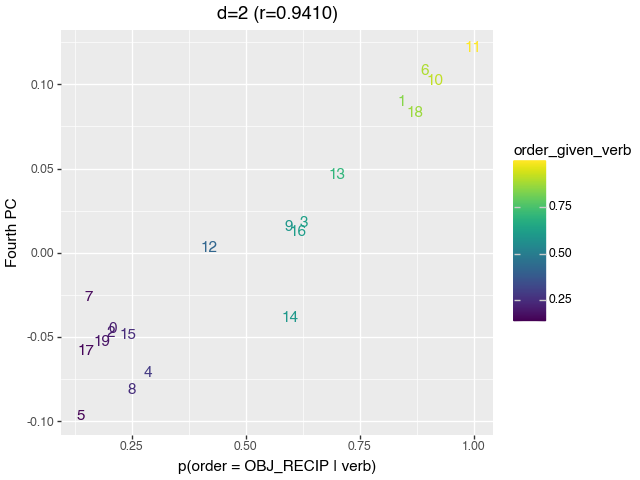

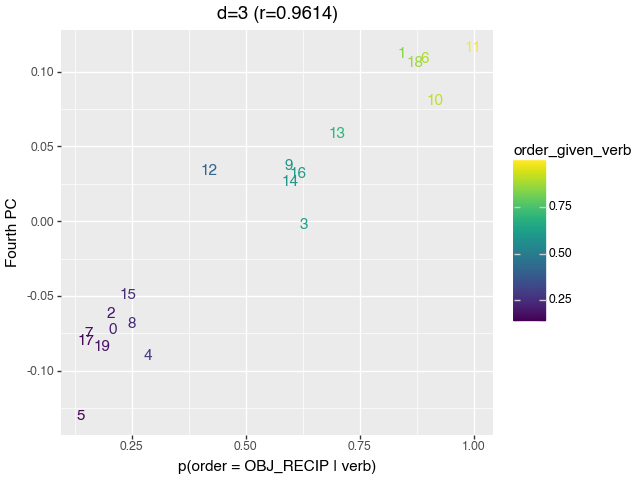

In [26]:
# use svg in jupyter
%config InlineBackend.figure_format = 'png'

for d in model_dict:
    model = model_dict[d]
    embeddings = model.transformer.wte.weight.data
    pca = PCA(n_components=16)
    embeddings_pca = pca.fit_transform(embeddings)[language.VERB_START:language.NOUN_START, :]

    # make data frame
    df = pd.DataFrame(embeddings_pca[:, 4], columns=['pca'])
    df['index'] = df.index.map(lambda i: i)
    df['order_given_verb'] = df.index.map(lambda i: language.p_order_given_verb[i, 0].item())

    # compute correlation b/w class_given_noun and y
    r = r_regression(df['order_given_verb'].to_numpy().reshape(-1, 1), df['pca'].to_numpy()).item()

    plot = (
        p9.ggplot(df, p9.aes(x='order_given_verb', y='pca', color='order_given_verb'))
        + p9.geom_text(p9.aes(label='index'))
        + p9.labs(x="p(order = OBJ_RECIP | verb)", y="Fourth PC", title=f"d={d} (r={r:.4f})")
    )
    plot.show()


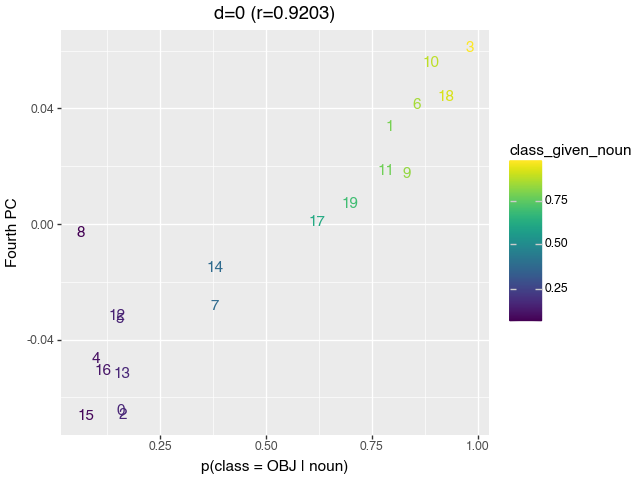

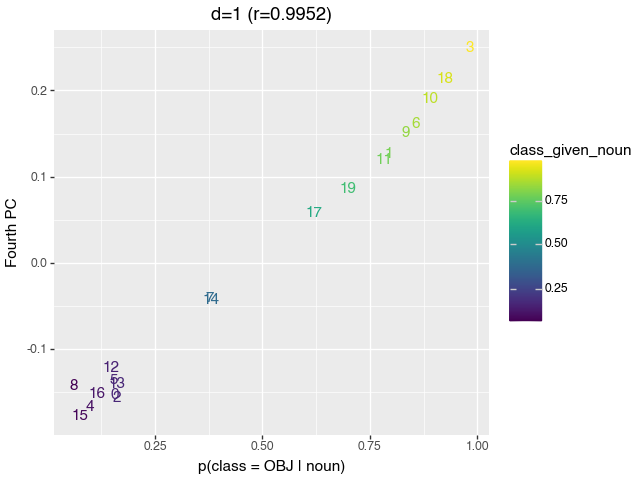

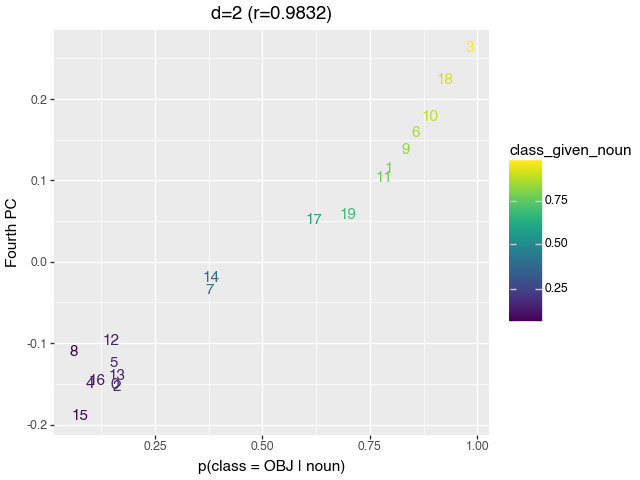

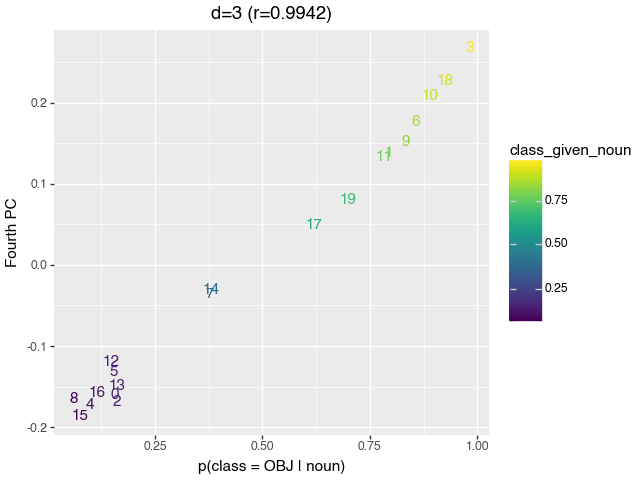

In [27]:
# use svg in jupyter
%config InlineBackend.figure_format = 'png'

for d in model_dict:
    model = model_dict[d]
    embeddings = model.transformer.wte.weight.data
    pca = PCA(n_components=16)
    embeddings_pca = pca.fit_transform(embeddings)[language.NOUN_START:, :]

    # make data frame
    df = pd.DataFrame(embeddings_pca[:, 3], columns=['pca'])
    df['index'] = df.index.map(lambda i: i)
    df['class_given_noun'] = df.index.map(lambda i: language.p_class_given_noun[i, 0].item())

    # compute correlation b/w class_given_noun and y
    r = r_regression(df['class_given_noun'].to_numpy().reshape(-1, 1), df['pca'].to_numpy()).item()

    plot = (
        p9.ggplot(df, p9.aes(x='class_given_noun', y='pca', color='class_given_noun'))
        + p9.geom_text(p9.aes(label='index'))
        + p9.labs(x="p(class = OBJ | noun)", y="Fourth PC", title=f"d={d} (r={r:.4f})")
    )
    plot.show()


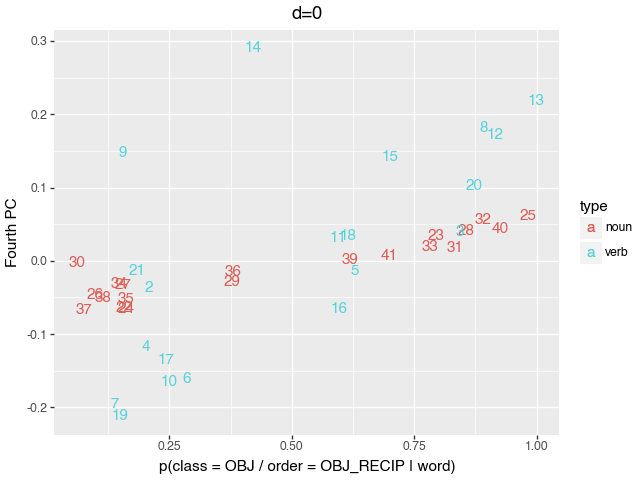

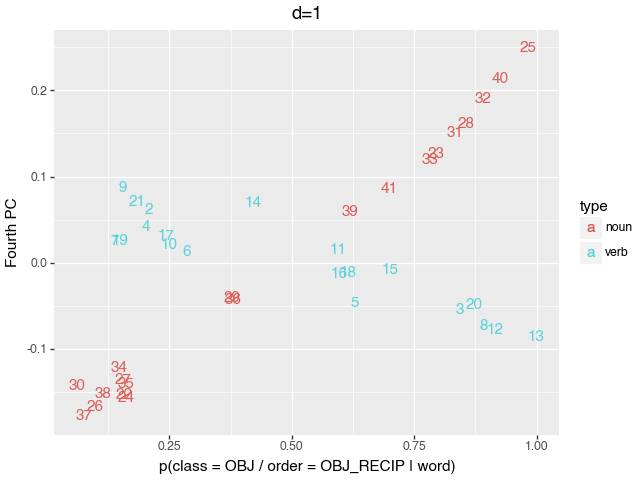

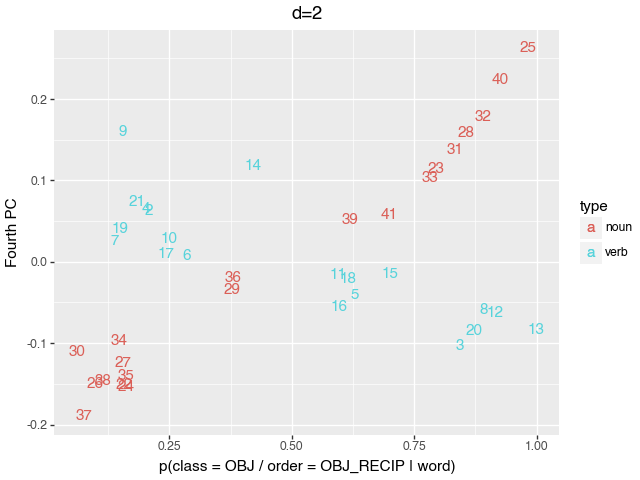

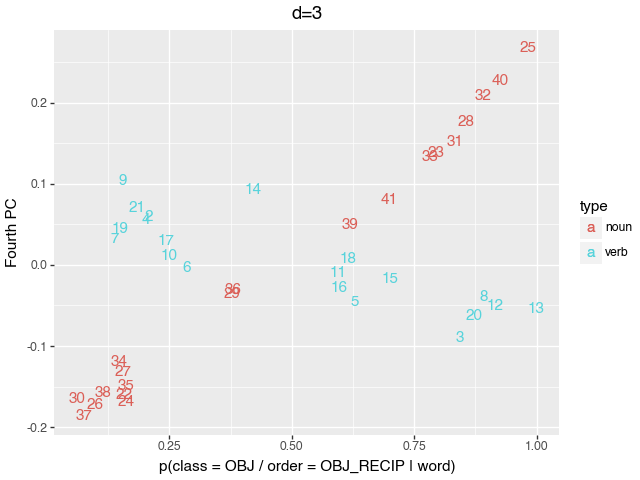

In [30]:
# use svg in jupyter
%config InlineBackend.figure_format = 'png'

for d in model_dict:
    model = model_dict[d]
    embeddings = model.transformer.wte.weight.data
    pca = PCA(n_components=16)
    embeddings_pca = pca.fit_transform(embeddings)

    # make data frame
    df = pd.DataFrame(embeddings_pca[:, 3], columns=['pca'])
    df['index'] = df.index.map(lambda i: i)
    df['type'] = df.index.map(color_by_verb_noun)
    df['order_given_verb'] = df.index.map(lambda i: language.p_order_given_verb[i - language.VERB_START, 0].item() if i >= language.VERB_START and i < language.NOUN_START else None)
    df['class_given_noun'] = df.index.map(lambda i: language.p_class_given_noun[i - language.NOUN_START, 0].item() if i >= language.NOUN_START else None)

    plot = (
        p9.ggplot()
        + p9.geom_text(df[df['type'] == 'noun'], p9.aes(x='class_given_noun', y='pca', color='type', label='index'))
        + p9.geom_text(df[df['type'] == 'verb'], p9.aes(x='order_given_verb', y='pca', color='type', label='index'))
        + p9.labs(x="p(class = OBJ / order = OBJ_RECIP | word)", y="Fourth PC", title=f"d={d}")
    )
    plot.show()
